See: https://github.com/dmitrymailk/ru_lm/blob/73dbb763d2618af586c5798c777dd85dc5edf40f/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/FastChat/fastchat/llm_judge/noteboooks/mt_bench_radar.ipynb

In [10]:
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import glob
from pprint import pprint
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

Get unique categories

In [11]:
def extract_unique_categories(jsonl_file):
    categories = set()  # Using a set to ensure uniqueness

    with open(jsonl_file, 'r') as file:
        for line in file:
            entry = json.loads(line)
            categories.add(entry['category'])

    return list(categories)  # Convert the set to a list

def get_questions(jsonl_file):
    questions = []
    with open(jsonl_file, 'r') as file:
        for line in file:
            question = json.loads(line)
            questions.append(question)
    return questions

# Usage
jsonl_file = 'data/japanese_mt_bench/question_full.jsonl'
CATEGORIES = extract_unique_categories(jsonl_file)
pprint(CATEGORIES)

QUESTIONS = get_questions(jsonl_file)
QUESTIONS[0]

['roleplay',
 'reasoning',
 'coding',
 'writing',
 'humanities',
 'extraction',
 'stem',
 'math']


{'question_id': 1,
 'category': 'coding',
 'turns': ['ディレクトリ内の全てのテキストファイルを読み込み、出現回数が最も多い上位5単語を返すPythonプログラムを開発してください。',
  'それを並列化（parallelize）することは可能ですか？']}

In [12]:
def glob_jsonl_files(folder_path):
    models = []
    file_pattern = folder_path + '/*.jsonl'  # Pattern to match .jsonl files in the folder
    for file_path in glob.glob(file_pattern):
        filename = file_path.split('/')[-1]  # Extract filename from the full path
        model_name = filename.split('__')[0]  # Split by '__' and take the first part
        models.append(model_name)
    return models

# Usage
folder_path = 'data/japanese_mt_bench/model_judgment/gpt-4_single'  # Replace with your folder path
MODELS = sorted(glob_jsonl_files(folder_path))
MODELS

['Qwen-14B-Chat',
 'Qwen-72B-Chat',
 'Swallow-70b-instruct-GPTQ',
 'Xwin-LM-70B-V0.1-GPTQ',
 'chatntq-nekomata-14b',
 'gpt-4',
 'gpt-4-1106-preview',
 'houou-instruction-7b-v1',
 'houou-instruction-7b-v1-correctedtemplate',
 'houou-instruction-7b-v1-correctedtemplate2',
 'llm-jp-13b-instruct-full-jaster-dolly-oasst-v1.0',
 'llm-jp-13b-instruct-full-jaster-v1.0',
 'nekomata-14b-instruction',
 'nekomata-14b-instruction-correctedprompt',
 'nekomata-14b-instruction-correctedprompt-hf',
 'orionstarai-orion-14b-chat',
 'qlora_elyza-13b-fast_sharegpt-clean-ja',
 'qlora_orion-14b-chat_sharegpt-clean-ja',
 'qlora_qwen-14b-chat_sharegpt-clean-ja',
 'shisa-7B-v1-AWQ',
 'shisa-7B-v1-GPTQ',
 'shisa-7b-v1-fullprompt',
 'shisa-bad-7b-v1',
 'shisa-gamma-7b-v1',
 'shisa-mega-7b-v1.2',
 'shisa-mega-7b-v1.2-dpo',
 'shisa-mega-dpo-7b-v1.1',
 'tokyotech-llm_Swallow-13b-instruct-hf',
 'tokyotech-llm_Swallow-7b-instruct-hf']

In [13]:
# Models
models = {}
for model in MODELS:
    models[model] = {}


In [14]:
# For Plotting
def get_model_df(model):
    cnt = 0
    q2result = []
    with open(f"data/japanese_mt_bench/model_judgment/gpt-4_single/{model}__1turn.jsonl", "r") as file:
        for line in file:
            q = json.loads(line)

            # Match question w/ category
            for item in QUESTIONS:
                if item['question_id'] == q['question_id']:
                    q['category'] = item['category']
                    break

            q2result.append(q)
    df = pd.DataFrame(q2result)
    return df

for model in models:
    df = get_model_df(model)
    models[model]['df'] = df
    models[model]['avg'] = df['score'].mean()
    models[model]['avg_by_cat'] = df.groupby('category')['score'].mean()

In [15]:
# Let's see the scoreboard
sorted_models = sorted(models.items(), key=lambda x: x[1]['avg'], reverse=True)
df = pd.DataFrame([(model_name, model_info['avg']) for model_name, model_info in sorted_models], 
                  columns=['Model', 'Average Score'])

# Constructing the DataFrame
rows = []
for model_name, model_info in sorted_models:
    # Convert Series to dictionary for easier access
    category_scores = model_info['avg_by_cat'].to_dict()
    # List comprehension to extract values for each category
    row = [model_name, model_info['avg']] + [category_scores.get(category) for category in category_scores]
    rows.append(row)

# Define column names
column_names = ['Model', 'Average Score'] + list(category_scores.keys())


# Create DataFrame
df = pd.DataFrame(rows, columns=column_names)

# https://mwouts.github.io/itables/quick_start.html
import itables
itables.show(df.round(2), paging=False)
# from itables import to_html_datatable
# to_html_datatable(df.round(2), paging=False)


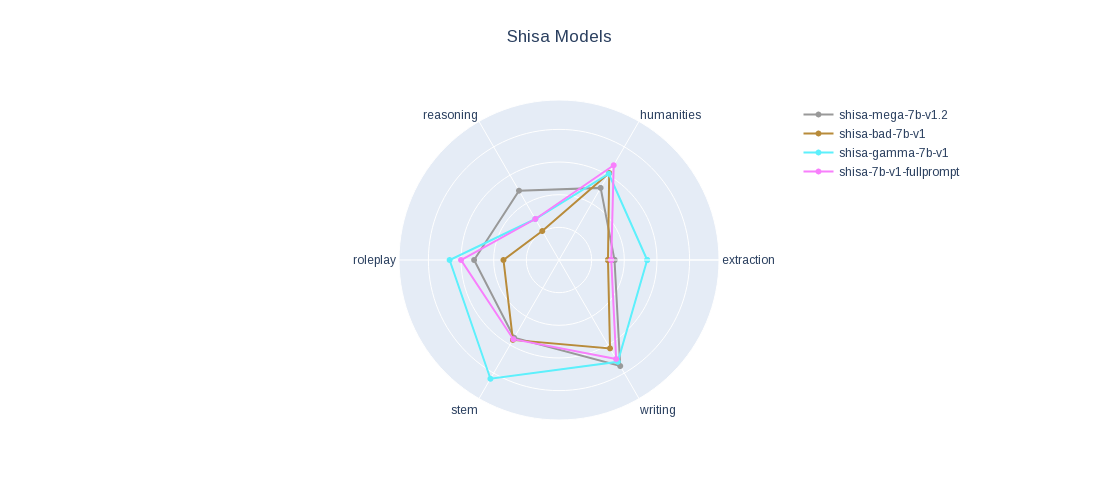

In [16]:
def plot_radar(df, plot_title, models_and_colors):
    # Extracting categories from DataFrame columns, excluding the 'Model' column
    categories = [col for col in df.columns if col not in ['Model', 'Average Score']]

    # Create traces for each model, skipping models with missing values in any category
    traces = []
    for model, color in models_and_colors:
        if model in df['Model'].values:
            model_data = df[df['Model'] == model].dropna(subset=categories)
            if not model_data.empty:
                model_data = model_data[categories].iloc[0]
                # Adding the first category score again to close the radar plot
                r_values = model_data.tolist() + [model_data.iloc[0]]
                theta_values = categories + [categories[0]]
                traces.append(go.Scatterpolar(
                    r=r_values,
                    theta=theta_values,
                    name=model,
                    line=dict(color=color),
                    fill=None  # No fill, only line
                ))

    # Layout
    layout = go.Layout(
        # title=plot_title,  # Set the title
        title={
            'text': plot_title,
            'y':0.94,
            'x':0.5,  # Center align
            'xanchor': 'center',  # Ensure the title is centered
            'yanchor': 'top'
        },
        polar=dict(
            radialaxis=dict(
                visible=True,
                showticklabels=False,
                nticks=5,
                range=[0, df[categories].max().max()]  # Adjust the range based on your data
            )
        ),
        showlegend=True,
        legend=dict(
            orientation="v",
            x=0.75,  # Position legend outside the plot to the right
            y=1
        ),
        height=500,
    )

    fig = go.Figure(data=traces, layout=layout)
    fig.show()

plot_radar(df, 'Shisa Models',
[
    ('shisa-mega-7b-v1.2', '#999'),
    ('shisa-bad-7b-v1', '#b88b3a'),
    ('shisa-gamma-7b-v1', '#5df0fc'),
    ('shisa-7b-v1-fullprompt', '#f87ffc'),

])

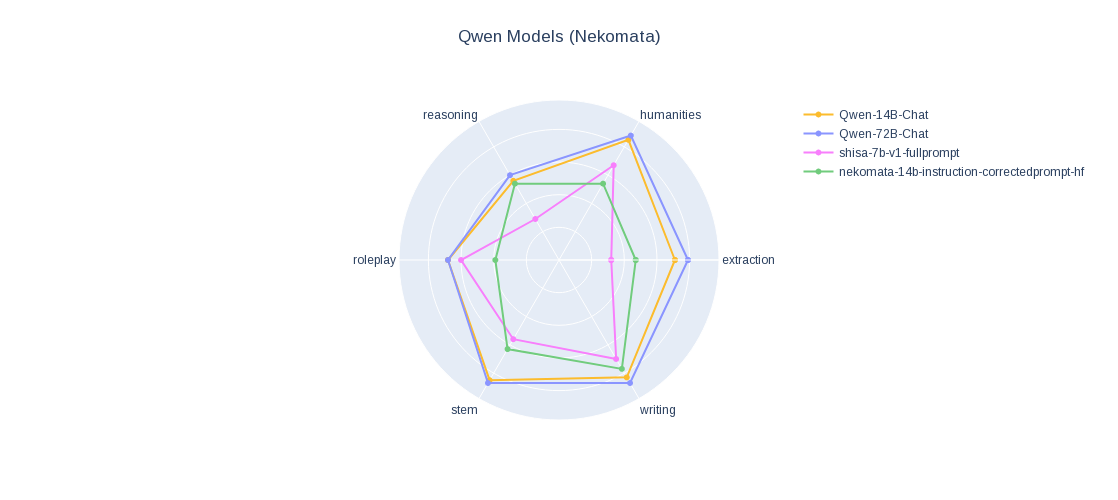

In [17]:
plot_radar(df, 'Qwen Models (Nekomata)',
[
    ('Qwen-14B-Chat', '#fcbc2d'),
    ('Qwen-72B-Chat', '#8a95ff'),
    ('shisa-7b-v1-fullprompt', '#f87ffc'),
    ('nekomata-14b-instruction-correctedprompt-hf', '#71cc7d'),
])

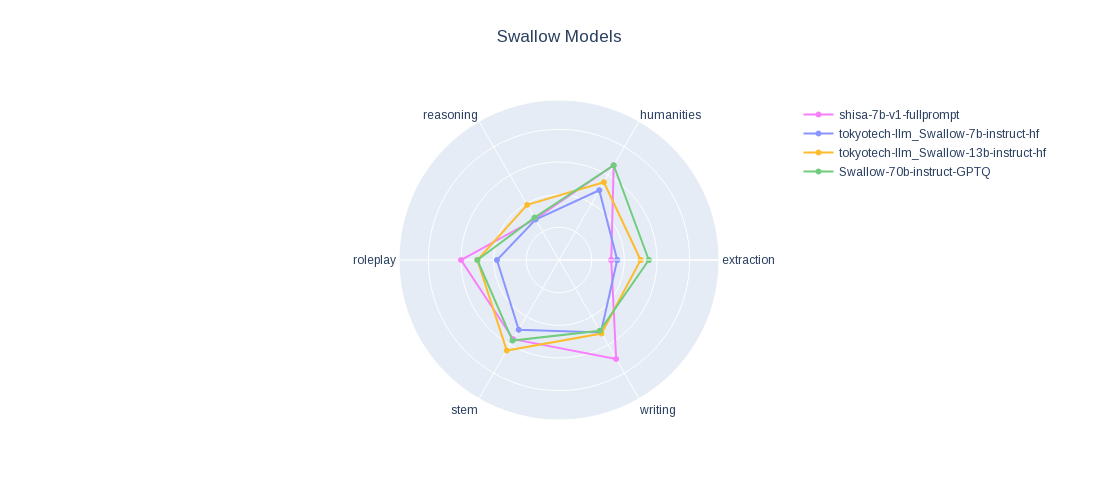

In [18]:
plot_radar(df, 'Swallow Models',
[
    ('shisa-7b-v1-fullprompt', '#f87ffc'),
    ('tokyotech-llm_Swallow-7b-instruct-hf', '#8a95ff'),
    ('tokyotech-llm_Swallow-13b-instruct-hf', '#fcbc2d'),
    ('Swallow-70b-instruct-GPTQ', '#71cc7d'),
])

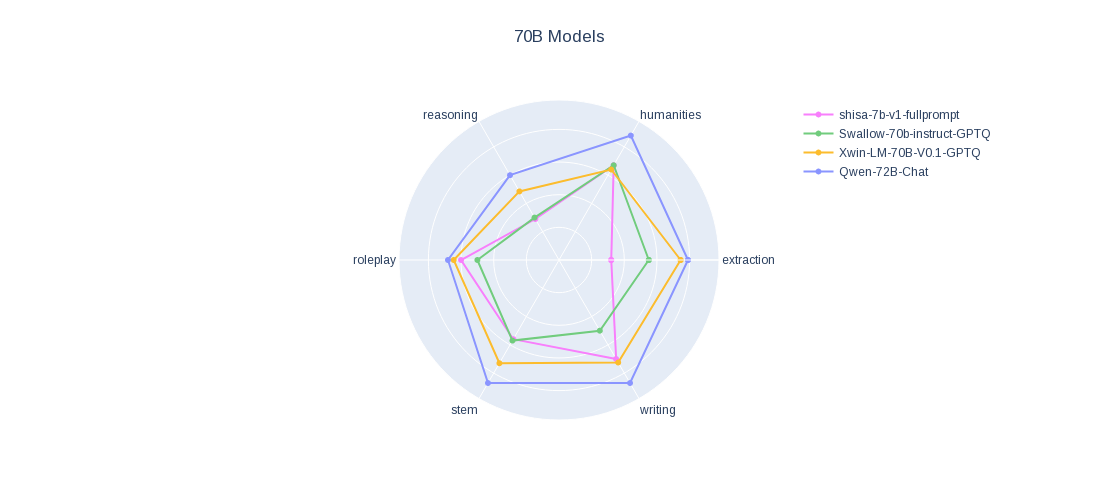

In [19]:
plot_radar(df, '70B Models',
[
    ('shisa-7b-v1-fullprompt', '#f87ffc'),
    ('Swallow-70b-instruct-GPTQ', '#71cc7d'),
    ('Xwin-LM-70B-V0.1-GPTQ', '#fcbc2d'),
    ('Qwen-72B-Chat', '#8a95ff'),
])

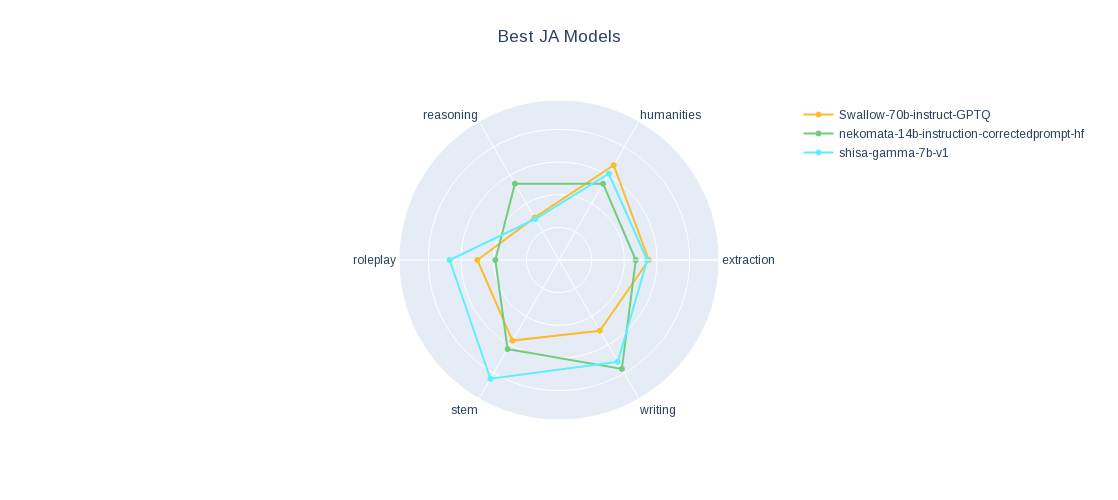

In [20]:
plot_radar(df, 'Best JA Models',
[
    ('Swallow-70b-instruct-GPTQ', '#fcbc2d'),
    ('nekomata-14b-instruction-correctedprompt-hf', '#71cc7d'),
    ('shisa-gamma-7b-v1', '#5df0fc'),
])

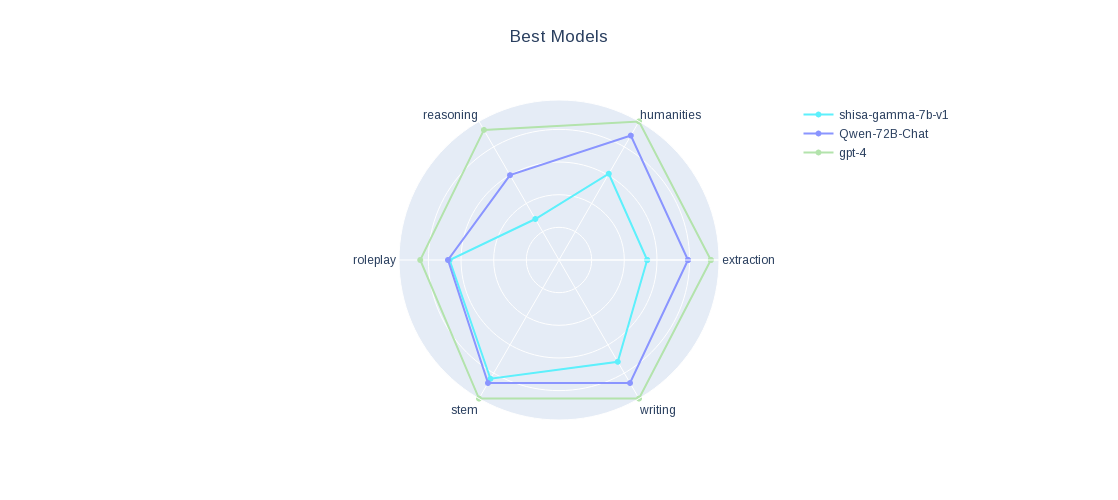

In [21]:
plot_radar(df, 'Best Models',
[
    ('shisa-gamma-7b-v1', '#5df0fc'),
    ('Qwen-72B-Chat', '#8a95ff'),
    ('gpt-4', '#b3e3ac'),
])

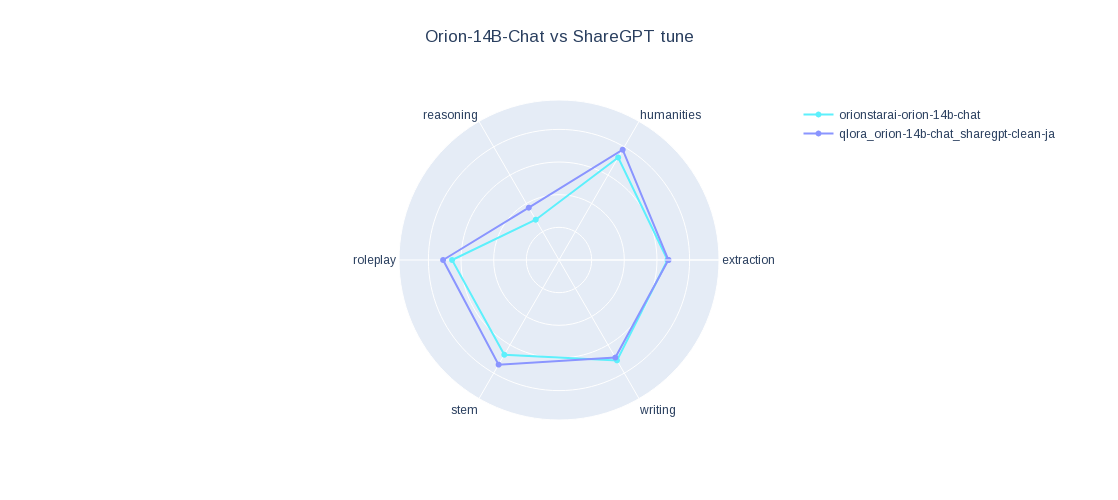

In [27]:
plot_radar(df, 'Orion-14B-Chat vs ShareGPT tune',
[
    ('orionstarai-orion-14b-chat', '#5df0fc'),
    ('qlora_orion-14b-chat_sharegpt-clean-ja', '#8a95ff'),
])

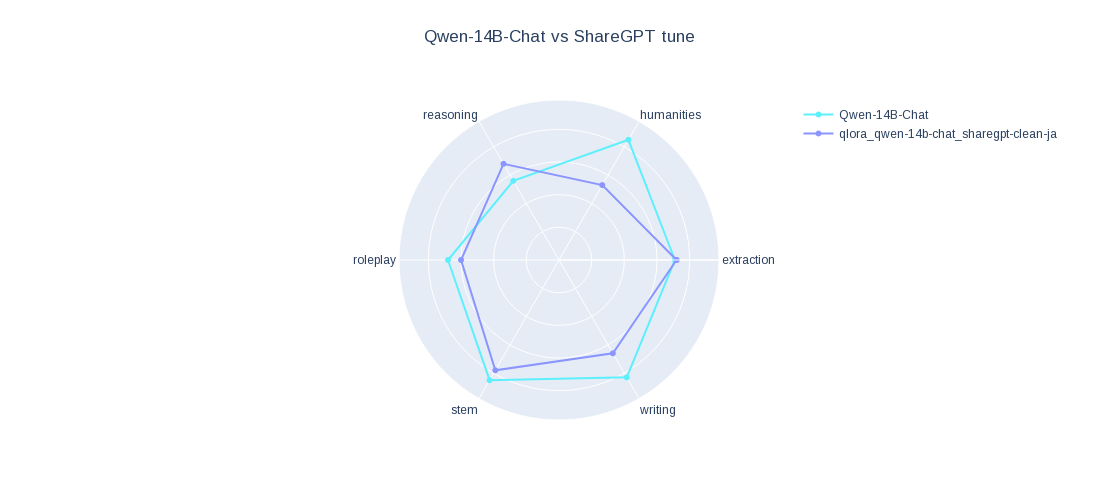

In [28]:
plot_radar(df, 'Qwen-14B-Chat vs ShareGPT tune',
[
    ('Qwen-14B-Chat', '#5df0fc'),
    ('qlora_qwen-14b-chat_sharegpt-clean-ja', '#8a95ff'),
])

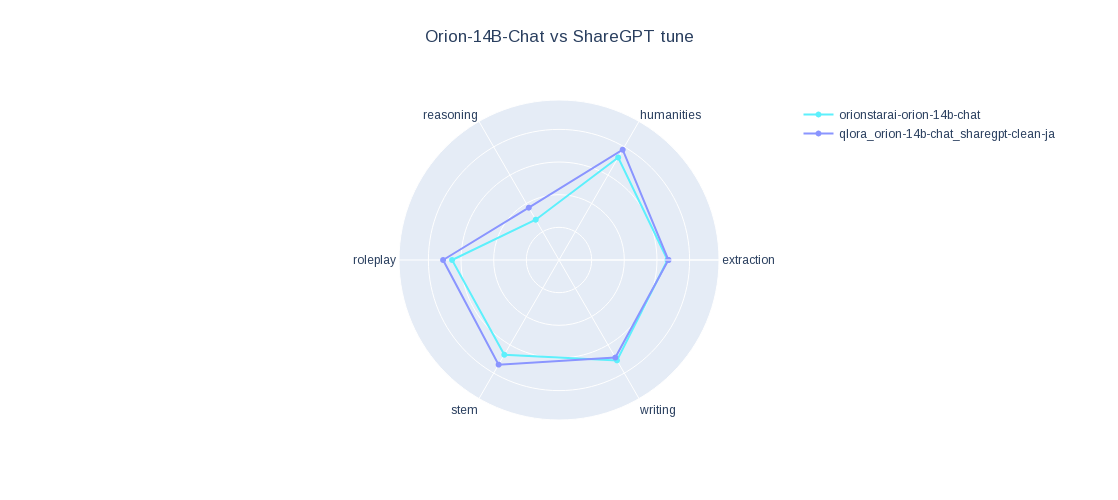

In [34]:
plot_radar(df, 'Orion-14B-Chat vs ShareGPT tune',
[
    ('orionstarai-orion-14b-chat', '#5df0fc'),
    ('qlora_orion-14b-chat_sharegpt-clean-ja', '#8a95ff'),
])

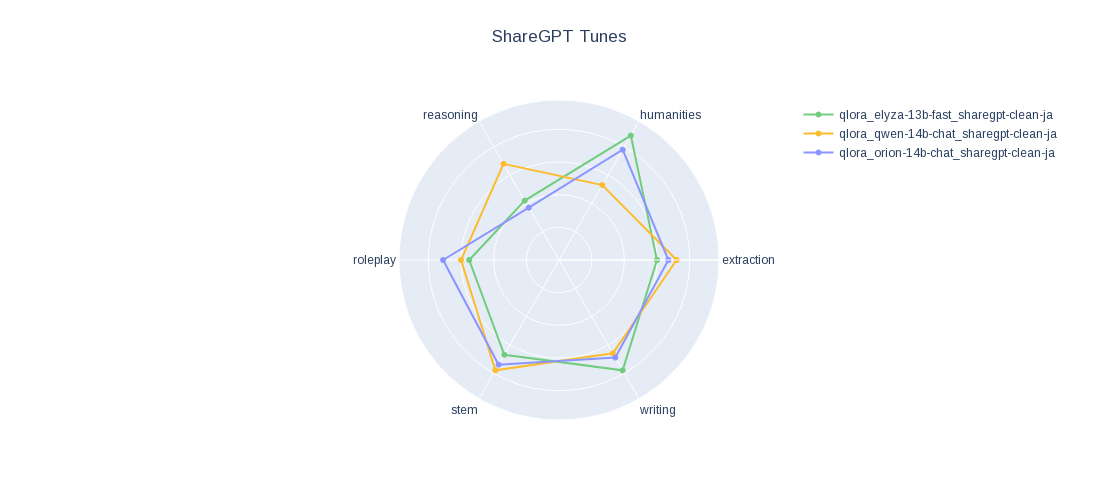

In [33]:
plot_radar(df, 'ShareGPT Tunes',
[
    ('chatntq-ja-7b-v1.0', '#f87ffc'),
    ('qlora_elyza-13b-fast_sharegpt-clean-ja', '#71cc7d'),
    ('qlora_qwen-14b-chat_sharegpt-clean-ja', '#fcbc2d'),
    ('qlora_orion-14b-chat_sharegpt-clean-ja', '#8a95ff'),
])